# TRAIN 

## Note:

> - this version has 7 classes including {'alarm': 0, 'en_help': 1, 'ch_help': 2, 'ja_help': 3, 'tw_help': 4, 'hk_help': 5, 'Environment': 6}

> - padding zero have two types: 'a' and 'ab', next part need to do another process like augmentation.  &nbsp;&nbsp; <sub><sub>240827</sub></sub>



## setting

In [29]:
project_PATH = '/home/sail/sound_project/sound_ai_v2'
step_now = 'STEP/step_1'

In [30]:
import os
print(os.getcwd())
import sys
sys.path.append(os.path.abspath(f'{project_PATH}/common'))

import utils as U
import opts as opts;
import calculator as calc;
import tlopts as tlopts

from config_utility import *

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from datetime import datetime

/home/sail/sound_project/sound_ai_v2/STEP/step_1


In [31]:
import sys;
import os;
import glob;
import math;
import numpy as np;
import glob;
import random;
import time;
import torch;
from torch.utils.data import  DataLoader
import torch.optim as optim;
import torch.nn as nn;
import json

import argparse
from itertools import repeat
import pathlib

In [32]:
date_time = datetime.now().strftime("%Y%m%d_%H")  # %M
save_pt_model_path = f'{project_PATH}/{step_now}/save_pt_model_s1/{date_time}'
try:
    os.mkdir(save_pt_model_path)
    print(f"Folder '{save_pt_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_pt_model_path}' already exists.")

Folder '/home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11' already exists.


In [33]:
#Reproducibility
seed = 1123;
random.seed(seed);
np.random.seed(seed);
torch.manual_seed(seed);
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed);
torch.backends.cudnn.deterministic = True;
torch.backends.cudnn.benchmark = False;

In [34]:
pretrained_acdnet = f'{project_PATH}/common/acdnet_20khz_trained_model_fold4_91.00.pt'

In [35]:
def ChkAndCreateSingleDir(dir_path):
    if not pathlib.Path(dir_path).is_dir():
        os.mkdir(dir_path);
        print(f"'{dir_path}' folder is created.");

In [36]:
#log object
logObj = None;

In [37]:
inp_len = 20150
sr = 20150
choose_class=[0,1,2,3,4,5,6]
PATH = f'{project_PATH}/STEP/data_v2.npz'

In [38]:
data = np.load(PATH, allow_pickle=True) 
audio_max_value =  float((data['sounds_train']).max())*2 # the max value of the sound samples
audio_min_value =  float((data['sounds_train']).min())*2 # the max value of the sound samples
audio_max_value, audio_min_value

(3.0242209434509277, -3.1673121452331543)

In [39]:
order = [0,1,2,3,4,5,6]

def one_hot_encode(data, order):
    index_map = {number: index for index, number in enumerate(order)}
    one_hot_list = []

    for num in data:
        one_hot = [0] * len(order)
        if num in index_map:
            one_hot[index_map[num]] = 1
        one_hot_list.append(one_hot)

    return one_hot_list

## define TLTraining Generator Class
The Class is an python iterator class for generating data for trainer to train the model.

In [40]:
class TLGenerator():
    #Generates data for Keras
    def __init__(self, samples=None, labels=None, options=None, classes_dict=None, preprocess_type=None):
        random.seed(1123);
        #Initialization
        self.data = [(samples[i], labels[i]) for i in range (0, len(samples))];
        self.opt = options;
        self.batch_size = options.batchSize;
        self.preprocess_funcs = self.preprocess_setup(); # preprocess_type
        self.mapdict = classes_dict
    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size));

    def __getitem__(self, batchIndex):
        #Generate one batch of data
        batchX, batchY = self.generate_batch_select_fixed_class(batchIndex);  # generate_batch  or  generate_batch_select_fixed_class
        batchX = np.expand_dims(batchX, axis=1);
        batchX = np.expand_dims(batchX, axis=3);
        return batchX, batchY

    def generate_batch(self, batchIndex): # if you don't want to fixed the class you can use this without generate_batch_select_fixed_class
        #Generates data containing batch_size samples
        sounds = [];
        labels = [];
        indexes = None;

        for i in range(self.batch_size):
            # Training phase of BC learning
            # Select two training examples
            while True:
                sound1, label1 = self.data[random.randint(0, len(self.data) - 1)]
                sound2, label2 = self.data[random.randint(0, len(self.data) - 1)]
                if label1 != label2:
                    break
            sound1 = self.preprocess(sound1)
            sound2 = self.preprocess(sound2)

            # Mix two examples
            r = np.array(random.random())
            sound = U.mix(sound1, sound2, r, self.opt.sr).astype(np.float32)
            eye = np.eye(self.opt.nClasses)
            idx1 = self.mapdict[str(label1)]- 1
            idx2 = self.mapdict[str(label2)] - 1
            label = (eye[idx1] * r + eye[idx2] * (1 - r)).astype(np.float32)
            # label = (eye[label1] * r + eye[label2] * (1 - r)).astype(np.float32)

            #For stronger augmentation
            sound = U.random_gain(6)(sound).astype(np.float32) #################################################
            # print(f"sound length after U.random_gain is {len(sound)}")
            sounds.append(sound);
            labels.append(label);
            # print(f"---{label}---{sound.max()},{sound.min()}")
        sounds = np.asarray(sounds);
        labels = np.asarray(labels);

        return sounds, labels;

    def generate_batch_select_fixed_class(self, batchIndex):
        #Generates data containing batch_size samples
        sounds = [];
        labels = [];
        indexes = None;
        #two variables recording alarm and moaning sounds count
        alarm_selected, help_eng_selected, help_ch_selected, help_ja_selected, help_tw_selected, help_hk_selected = 0, 0, 0, 0, 0, 0

        for i in range(self.batch_size):
            # Training phase of BC learning
            # Select two training examples
            while True:
                # print("enter while true")
                sound1, label1 = self.data[random.randint(0, len(self.data) - 1)]
                sound2, label2 = self.data[random.randint(0, len(self.data) - 1)]
                lbl1_int = np.int16(label1);
                lbl2_int = np.int16(label2);
                # if label1 != label2:
                    # {'alarm': 0, 'en_help': 1, 'ch_help': 2, 'ja_help': 3, 'tw_help': 4, 'hk_help': 5, 'Environment': 6, 'other': 7}
                    # if (lbl1_int == 0 and lbl2_int == 6) or (lbl1_int == 6 and lbl2_int ==0):
                    #     if (alarm_selected == moaning_selected) and (alarm_selected == help_eng_selected):
                    #         alarm_selected += 1;
                    #         break;
                    # if (lbl1_int == 1 and lbl2_int == 6) or (lbl1_int == 6 and lbl2_int == 1):
                    #     if (moaning_selected < alarm_selected) and (moaning_selected == help_eng_selected):
                    #         moaning_selected += 1;
                    #         break;
                    # if (lbl1_int == 2 and lbl2_int == 6) or (lbl1_int == 6 and lbl2_int == 2):
                    #     if (help_eng_selected < alarm_selected) and (help_eng_selected < moaning_selected):
                    #         help_eng_selected += 1;
                    #         break;
                    # if (lbl1_int == 3 and lbl2_int == 6) or (lbl1_int == 6 and lbl2_int == 3):
                    #     if (help_eng_selected < alarm_selected) and (help_eng_selected < moaning_selected):
                    #         help_eng_selected += 1;
                    #         break;
                    # if (lbl1_int == 4 and lbl2_int == 6) or (lbl1_int == 6 and lbl2_int == 4):
                    #     if (help_eng_selected < alarm_selected) and (help_eng_selected < moaning_selected):
                    #         help_eng_selected += 1;
                    #         break;
                    # if (lbl1_int == 5 and lbl2_int == 6) or (lbl1_int == 5 and lbl2_int == 4):
                    #     if (help_eng_selected < alarm_selected) and (help_eng_selected < moaning_selected):
                    #         help_eng_selected += 1;
                if label1 != label2:
                    # {'alarm': 0, 'en_help': 1, 'ch_help': 2, 'ja_help': 3, 'tw_help': 4, 'hk_help': 5, 'Environment': 6, 'other': 7}
                    if (lbl1_int == 0 and lbl2_int == 6) or (lbl1_int == 6 and lbl2_int ==0):
                        if (alarm_selected == help_ch_selected) and (alarm_selected == help_eng_selected):
                            alarm_selected += 1;
                            break;
                    if (lbl1_int == 1 and lbl2_int == 6) or (lbl1_int == 6 and lbl2_int == 1):
                        if (help_eng_selected < alarm_selected) and (help_eng_selected == help_ch_selected):
                            help_eng_selected += 1;
                            break;
                    if (lbl1_int == 2 and lbl2_int == 6) or (lbl1_int == 6 and lbl2_int == 2):
                        if (help_ch_selected < alarm_selected) and (help_ch_selected < help_eng_selected):
                            help_ch_selected += 1;
                            break;
                    if (lbl1_int == 3 and lbl2_int == 6) or (lbl1_int == 6 and lbl2_int == 3):
                        if (help_ja_selected < alarm_selected) and (help_ja_selected < help_ch_selected):
                            help_ja_selected += 1;
                            break;
                    if (lbl1_int == 4 and lbl2_int == 6) or (lbl1_int == 6 and lbl2_int == 4):
                        if (help_tw_selected < alarm_selected) and (help_tw_selected < help_ch_selected):
                            help_tw_selected += 1;
                            break;
                    if (lbl1_int == 5 and lbl2_int == 6) or (lbl1_int == 5 and lbl2_int == 4):
                        if (help_hk_selected < alarm_selected) and (help_hk_selected < help_ch_selected):
                            help_hk_selected += 1;                    
                            break;
            sound1 = self.preprocess(sound1)
            sound2 = self.preprocess(sound2)

            # Mix two examples
            r = np.array(random.random());
            sound = U.mix(sound1, sound2, r, self.opt.sr).astype(np.float32)
            eye = np.eye(self.opt.nClasses)
            idx1 = label1 # self.mapdict[str(label1)]- 1
            idx2 = label2 # self.mapdict[str(label2)] - 1
            label = (eye[idx1] * r + eye[idx2] * (1 - r)).astype(np.float32)
            # normalize_func = U.normalize(audio_max_value)  

            #For stronger augmentation
            sound = U.random_gain(6)(sound).astype(np.float32)
            # print(f"sound length after U.random_gain is {len(sound)}")
            sounds.append(sound)
            labels.append(label);

        sounds = np.asarray(sounds);
        labels = np.asarray(labels);
        # print(f"---{label}---{sound.max()},{sound.min()}")
        return sounds, labels;

    def preprocess_setup(self):
        funcs = []
        if self.opt.strongAugment:
            funcs += [U.random_scale(1.25)]

        funcs += [U.padding(self.opt.inputLength // 2),
                  U.random_crop(self.opt.inputLength),
                  U.regularization(audio_max_value, audio_min_value),  # 
                #   U.normalize(audio_max_value)
                  ]
        # if type == "regular":
        #     funcs += [U.normalize(audio_max_value)]
        return funcs

    def preprocess(self, sound):
        for f in self.preprocess_funcs:
            sound = f(sound)
        return sound;

## ACDNetV2 define the acdnet model structure.
定義原本的ACDNetV2，for載入pretrained acdnet model.

In [41]:
class ACDNetV2(nn.Module):
    def __init__(self, input_length, n_class, sr, ch_conf=None):
        super(ACDNetV2, self).__init__();
        self.input_length = input_length;
        self.ch_config = ch_conf;

        stride1 = 2;
        stride2 = 2;
        channels = 8;
        k_size = (3, 3);
        n_frames = (sr/1000)*10; #No of frames per 10ms

        sfeb_pool_size = int(n_frames/(stride1*stride2));
        # tfeb_pool_size = (2,2);
        if self.ch_config is None:
            self.ch_config = [channels, 
                              channels*8, 
                              channels*4, 
                              channels*8, 
                              channels*8, 
                              channels*16, channels*16, 
                              channels*32, channels*32, 
                              channels*64, channels*64, n_class];
        # avg_pool_kernel_size = (1,4) if self.ch_config[1] < 64 else (2,4);
        fcn_no_of_inputs = self.ch_config[-1];
        conv1, bn1 = self.make_layers(1, self.ch_config[0], (1, 9), (1, stride1));
        conv2, bn2 = self.make_layers(self.ch_config[0], self.ch_config[1], (1, 5), (1, stride2));
        conv3, bn3 = self.make_layers(1, self.ch_config[2], k_size, padding=1);
        conv4, bn4 = self.make_layers(self.ch_config[2], self.ch_config[3], k_size, padding=1);
        conv5, bn5 = self.make_layers(self.ch_config[3], self.ch_config[4], k_size, padding=1);
        conv6, bn6 = self.make_layers(self.ch_config[4], self.ch_config[5], k_size, padding=1);
        conv7, bn7 = self.make_layers(self.ch_config[5], self.ch_config[6], k_size, padding=1);
        conv8, bn8 = self.make_layers(self.ch_config[6], self.ch_config[7], k_size, padding=1);
        conv9, bn9 = self.make_layers(self.ch_config[7], self.ch_config[8], k_size, padding=1);
        conv10, bn10 = self.make_layers(self.ch_config[8], self.ch_config[9], k_size, padding=1);
        conv11, bn11 = self.make_layers(self.ch_config[9], self.ch_config[10], k_size, padding=1);
        conv12, bn12 = self.make_layers(self.ch_config[10], self.ch_config[11], (1, 1));
        fcn = nn.Linear(fcn_no_of_inputs, n_class);
        nn.init.kaiming_normal_(fcn.weight, nonlinearity='sigmoid') # kaiming with sigoid is equivalent to lecun_normal in keras

        self.sfeb = nn.Sequential(
            #Start: Filter bank
            conv1, bn1, nn.ReLU(),\
            conv2, bn2, nn.ReLU(),\
            nn.MaxPool2d(kernel_size=(1, sfeb_pool_size))
        );

        tfeb_modules = [];
        self.tfeb_width = int(((self.input_length / sr)*1000)/10); # 10ms frames of audio length in seconds
        tfeb_pool_sizes = self.get_tfeb_pool_sizes(self.ch_config[1], self.tfeb_width);
        p_index = 0;
        for i in [3,4,6,8,10]:
            tfeb_modules.extend([eval('conv{}'.format(i)), eval('bn{}'.format(i)), nn.ReLU()]);

            if i != 3:
                tfeb_modules.extend([eval('conv{}'.format(i+1)), eval('bn{}'.format(i+1)), nn.ReLU()]);

            h, w = tfeb_pool_sizes[p_index];
            if h>1 or w>1:
                tfeb_modules.append(nn.MaxPool2d(kernel_size = (h,w)));
            p_index += 1;

        tfeb_modules.append(nn.Dropout(0.2));
        tfeb_modules.extend([conv12, bn12, nn.ReLU()]);
        h, w = tfeb_pool_sizes[-1];
        if h>1 or w>1:
            tfeb_modules.append(nn.AvgPool2d(kernel_size = (h,w)));
        tfeb_modules.extend([nn.Flatten(), fcn]);

        self.tfeb = nn.Sequential(*tfeb_modules);

        self.output = nn.Sequential(
            nn.Softmax(dim=1)
        );


    def forward(self, x):
        x = self.sfeb(x);
        #swapaxes
        x = x.permute((0, 2, 1, 3));
        x = self.tfeb(x);
        y = self.output[0](x);
        return y;

    def make_layers(self, in_channels, out_channels, kernel_size, stride=(1,1), padding=0, bias=False):
        conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias);
        nn.init.kaiming_normal_(conv.weight, nonlinearity='relu'); # kaiming with relu is equivalent to he_normal in keras
        bn = nn.BatchNorm2d(out_channels);
        return conv, bn;

    def get_tfeb_pool_sizes(self, con2_ch, width):
        h = self.get_tfeb_pool_size_component(con2_ch);
        w = self.get_tfeb_pool_size_component(width);
        # print(w);
        pool_size = [];
        for  (h1, w1) in zip(h, w):
            pool_size.append((h1, w1));
        return pool_size;

    def get_tfeb_pool_size_component(self, length):
        # print(length);
        c = [];
        index = 1;
        while index <= 6:
            if length >= 2:
                if index == 6:
                    c.append(length);
                else:
                    c.append(2);
                    length = length // 2;
            else:
               c.append(1);
            index += 1;
        return c;

#GetACDNetModel中的nclass不能改50以外的值，因為pretrain model本來的分類為50，載入後，下面的函式會再改動後面的分類。
def GetACDNetModel(input_len=inp_len, nclass=50, sr=sr, channel_config=None):
    net = ACDNetV2(input_len, nclass, sr, ch_conf=channel_config);
    return net;

## load pretrained acdnet weights of 20khz

In [42]:
def getOpts():
    parser = argparse.ArgumentParser(description='Transfer Learning for ACDNet');
    parser.add_argument('--netType', default='ACDNet_TL_Model_Extend',  required=False);
    parser.add_argument('--data', default='../datasets/processed/',  required=False);
    parser.add_argument('--dataset', required=False, default='uec_iot', choices=['10']);
    parser.add_argument('--BC', default=True, action='store_true', help='BC learning');
    parser.add_argument('--strongAugment', default=True,  action='store_true', help='Add scale and gain augmentation');
    #在ipynb中，不能使用parser.parse，要改用parser.parse_known_args()
    opt, unknown = parser.parse_known_args();

    #Leqarning settings
    opt.batchSize =  32 #64;
    opt.LR = 0.05; # 0.1
    opt.weightDecay = 5e-4#9e-3;#5e-3;#5e-2;#1e-2;#5e-4;
    opt.momentum = 0.9 # 0.9;
    opt.nEpochs = 1000; # 1600
    opt.schedule = [0.1, 0.3, 0.5, 0.9];
    opt.warmup = 10;
    if torch.backends.mps.is_available():
        opt.device="mps"; #for apple m2 gpu
    elif torch.cuda.is_available():
        opt.device="cuda:0"; #for nVidia gpu
    else:
        opt.device="cpu"
    print(f"***Use device:{opt.device}");
    # opt.device = torch.device("cuda:0" if  else "cpu");
    #Basic Net Settings
    opt.nClasses = ch_n_class #50;######################################
    opt.nFolds = 1; ####################
    opt.splits = [i for i in range(1, opt.nFolds + 1)];
    opt.sr = sr;
    opt.inputLength = inp_len; ##############################
    #Test data
    opt.nCrops = 2;
    # opt.TLAcdnetConfig = [8,64,32,64,64,128,128,256,256,512,512,4];
    opt.TLAcdnetConfig = [8,32,64,128,4]#256,512,64,4];

    return opt
    # opt = parser.parse_args();

In [43]:
def make_layers(in_channels, out_channels, kernel_size, stride=(1,1), padding=0, bias=None):
        conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias);
        nn.init.kaiming_normal_(conv.weight, nonlinearity='relu'); # kaiming with relu is equivalent to he_normal in keras
        bn = nn.BatchNorm2d(out_channels);
        return conv, bn;

## modeling

In [44]:
ch_confing_10 = 8 * 32
ch_n_class = 7
fcn_no_of_inputs = 7
# conv12, bn12 = self.make_layers(self.ch_config[10], self.ch_config[11], (1, 1));
conv9, bn9 = make_layers(in_channels = ch_confing_10, out_channels = ch_n_class, kernel_size = (1, 1));
fcn = nn.Linear(fcn_no_of_inputs, ch_n_class);

In [45]:
kk = -18

In [46]:
class ACDNet_TL_Model_Extend(nn.Module):
    def __init__(self, PretrainedWeights='acdnet_20khz_trained_model_fold4_91.00.pt',opt=None):
        super(ACDNet_TL_Model_Extend, self).__init__()
        acdnet_model = GetACDNetModel(); # load original acdnet model first, note:n_classes is 50 because original acdnet
        # device = opt#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.opt = opt;
        self.ch_config = None;
        print(f"device is {self.opt.device}")
        pretrain_weight= torch.load(PretrainedWeights, map_location=torch.device(self.opt.device))['weight']
        model_state = acdnet_model.state_dict()
        model_state.update(pretrain_weight)
        acdnet_model.load_state_dict(pretrain_weight, strict=False)
        if self.ch_config is None:
            self.ch_config = opt.TLAcdnetConfig;
            #[channels, channels*8, channels*4, channels*8, channels*8, channels*16, channels*16, channels*32, channels*32, channels*64, channels*64, n_class];

        for k, v in acdnet_model.named_parameters():
            v.requires_grade = True;
            # v.requires_grad = False;
        # print(f"count is {count}");
        self.sfeb = nn.Sequential(*list(acdnet_model.children())[0])
        tfeb_modules = []
        tfeb_modules.extend([*list(acdnet_model.tfeb.children())[:kk]])
        tfeb_modules.extend([conv9, bn9, nn.ReLU()]);
        tfeb_modules.append(nn.AvgPool2d(kernel_size = (5,7)));  #############3
        tfeb_modules.extend([nn.Flatten(), fcn]);
        self.tfeb = nn.Sequential(*tfeb_modules)
        self.output = nn.Sequential(
        nn.Softmax(dim=1));

    def forward(self, x):
        x = self.sfeb(x);
        #swapaxes
        x = x.permute((0, 2, 1, 3));
        x = self.tfeb(x);
        y = self.output[0](x);
        return y;

In [47]:
class ACDNet_TL_Model_Extend_without_pretrained_weights(nn.Module):
    def __init__(self, PretrainedWeights='acdnet_20khz_trained_model_fold4_91.00.pt',opt=None):
        super(ACDNet_TL_Model_Extend_without_pretrained_weights, self).__init__()
        acdnet_model = GetACDNetModel(); # load original acdnet model first, note:n_classes is 50 because original acdnet
        # device = opt#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.opt = opt;
        self.ch_config = None;
        print(f"device is {self.opt.device}")
        if self.ch_config is None:
            self.ch_config = opt.TLAcdnetConfig;
            #[channels, channels*8, channels*4, channels*8, channels*8, channels*16, channels*16, channels*32, channels*32, channels*64, channels*64, n_class];
        self.sfeb = nn.Sequential(*list(acdnet_model.children())[0])
        tfeb_modules = []
        tfeb_modules.extend([*list(acdnet_model.tfeb.children())[kk]])
        tfeb_modules.extend([conv9, bn9, nn.ReLU()]);
        tfeb_modules.append(nn.AvgPool2d(kernel_size = (2,4)));
        tfeb_modules.extend([nn.Flatten(), fcn]);
        # self.retrained_layers = nn.Sequential(*list(acdnet_model.tfeb.children())[:-1])
        self.tfeb = nn.Sequential(*tfeb_modules)
        self.output = nn.Sequential(
        nn.Softmax(dim=1));

    def forward(self, x):
        print(f"sfeb:\n{list(self.sfeb.children())}");
        print(f"input x shape:{x.size()}")
        x = self.sfeb(x);
        #swapaxes
        x = x.permute((0, 2, 1, 3));
        x = self.tfeb(x);
        y = self.output[0](x);
        return y;

In [48]:
def GetTLACDNet(opt=None):
    model = ACDNet_TL_Model_Extend(PretrainedWeights=pretrained_acdnet, opt=opt);#ACDNet_TL_Model()
    # model = ACDNet_TL_Model_Extend_without_pretrained_weights(PretrainedWeights=None, opt=opt);
    return model
# def GetTLACDNet(opt=None):
#     model = ACDNet_TL_Model_Extend(PretrainedWeights=pretrained_acdnet, opt=opt);#ACDNet_TL_Model()
#     return model

In [49]:
from datetime import datetime;

In [50]:
def genDataTimeStr():
    return datetime.today().strftime('%Y-%m-%d %H:%M:%S').replace('-',"").replace(' ',"").replace(':',"");

In [51]:
class TLTrainer:
    global logObj;
    def __init__(self, opt=None, classes_dict=None):
        self.opt = opt;
        self.valX = None;
        self.valY = None;
        self.bestAcc = 0.0;
        self.bestAccEpoch = 0;
        self.trainGen = getTrainGen(opt,classes_dict=classes_dict)#train_generator.setup(opt, split);

    def Train(self):
        train_start_time = time.time();
        net = GetTLACDNet(self.opt).to(self.opt.device)#models.GetACDNetModel().to(self.opt.device);
        #print networks parameters' require_grade value
        for k_, v_ in net.named_parameters():
            print(f"{k_}:{v_.requires_grad}")
        print('ACDNet model has been prepared for training');

        calc.summary(net, (1,1,self.opt.inputLength));

        # training_text = "Re-Training" if self.opt.retrain else "Training from Scratch";
        # print("{} has been started. You will see update after finishing every training epoch and validation".format(training_text));

        lossFunc = torch.nn.KLDivLoss(reduction='batchmean');
        optimizer = optim.SGD(net.parameters(), lr=self.opt.LR, weight_decay=self.opt.weightDecay, momentum=self.opt.momentum, nesterov=True);

        # self.opt.nEpochs = 1957 if self.opt.split == 4 else 2000;
        for epochIdx in range(self.opt.nEpochs):
            epoch_start_time = time.time();
            optimizer.param_groups[0]['lr'] = self.__get_lr(epochIdx+1);
            cur_lr = optimizer.param_groups[0]['lr'];
            running_loss = 0.0;
            running_acc = 0.0;
            n_batches = math.ceil(len(self.trainGen.data)/self.opt.batchSize);
            for batchIdx in range(n_batches):
                # with torch.no_grad():
                x,y = self.trainGen.__getitem__(batchIdx)
                x = torch.tensor(np.moveaxis(x, 3, 1)).to(self.opt.device);
                y = torch.tensor(y).to(self.opt.device);
                # zero the parameter gradients
                optimizer.zero_grad();

                # forward + backward + optimize
                outputs = net(x);
                running_acc += (((outputs.data.argmax(dim=1) == y.argmax(dim=1))*1).float().mean()).item();
                loss = lossFunc(outputs.log(), y);
                loss.backward();
                optimizer.step();

                running_loss += loss.item();

            tr_acc = (running_acc / n_batches)*100;
            tr_loss = running_loss / n_batches;

            #Epoch wise validation Validation
            epoch_train_time = time.time() - epoch_start_time;

            net.eval();
            val_acc, val_loss = self.__validate(net, lossFunc);
            #Save best model
            # self.__save_model(val_acc, epochIdx, net);
            self.__save_model_refined(val_acc, tr_acc, epochIdx, net);
            self.__on_epoch_end(epoch_start_time, epoch_train_time, epochIdx, cur_lr, tr_loss, tr_acc, val_loss, val_acc);
            
            if (epochIdx + 1) % 50 == 0:
                self.__plot_confusion_matrix(net, epochIdx)

            running_loss = 0;
            running_acc = 0;
            net.train();

        total_time_taken = time.time() - train_start_time;
        print("Execution finished in: {}".format(U.to_hms(total_time_taken)));
        return net
    
    def __plot_confusion_matrix(self, net, epochIdx):
        # Ensure validation data is loaded
        if self.valX is None:
            self.load_choose_class_for_val(choose_class=choose_class)
        
        net.eval()
        with torch.no_grad():
            y_pred = net(self.valX).argmax(dim=1).cpu().numpy()
            y_true = self.valY.argmax(dim=1).cpu().numpy()
        
        cm = confusion_matrix(y_true, y_pred, labels=range(7))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(7))
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix at Epoch {epochIdx + 1}")
        plt.show()

    def load_choose_class_for_val(self, choose_class = choose_class): # *if you  want to choose the class
        data = np.load(self.opt.Data_npz_path, allow_pickle=True);
        print(f"device is :{self.opt.device}")
        print(f"len of Y:{len(data['labels_val'])}")
        index_for_class = [index for index, value in enumerate(data['labels_val']) if value in choose_class]
        labels_val = [data['labels_val'][index] for index in index_for_class]
        val_sounds = np.array([data['sounds_val'][index] for index in index_for_class])
        dataX = val_sounds.reshape(val_sounds.shape[0],1,1,val_sounds.shape[1]).astype(np.float32);
        self.valX = torch.tensor(dataX).to(self.opt.device);
        self.valY = torch.tensor(one_hot_encode(labels_val, order)).type(torch.float32).to(self.opt.device);

    def load_val_data(self): # *if you don't want to choose the class
        data = np.load(self.opt.Data_npz_path, allow_pickle=True);
        print(f"device is :{self.opt.device}")
        print(f"len of Y:{len(data['labels_val'])}")
        dataX = data['sounds_val'].reshape(data['sounds_val'].shape[0],1,1,data['sounds_val'].shape[1]).astype(np.float32);
        self.valX = torch.tensor(dataX).to(self.opt.device);
        self.valY = torch.tensor(one_hot_encode(data['labels_val'], order)).type(torch.float32).to(self.opt.device);

    def __get_lr(self, epoch):
        divide_epoch = np.array([self.opt.nEpochs * i for i in self.opt.schedule]);
        decay = sum(epoch > divide_epoch);
        if epoch <= self.opt.warmup:
            decay = 1;
        return self.opt.LR * np.power(0.1, decay);

    def __get_batch(self, index):
        x = self.trainX[index*self.opt.batchSize : (index+1)*self.opt.batchSize];
        y = self.trainY[index*self.opt.batchSize : (index+1)*self.opt.batchSize];
        return x.to(self.opt.device), y.to(self.opt.device);

    def __validate(self, net, lossFunc):
        if self.valX is None:
            self.load_choose_class_for_val(choose_class=choose_class);  # *change here   load_val_data
        net.eval();
        with torch.no_grad():
            y_pred = None;
            batch_size = len(self.valX);#(self.opt.batchSize//self.opt.nCrops)*self.opt.nCrops;

            x = self.valX[:];
            scores = net(x);
            y_pred = scores.data if y_pred is None else torch.cat((y_pred, scores.data));
            acc, loss = self.__compute_accuracy(y_pred, self.valY, lossFunc);

        net.train();
        return acc, loss;

    #Calculating average prediction (10 crops) and final accuracy
    def __compute_accuracy(self, y_pred, y_target, lossFunc):

        with torch.no_grad():
            #Reshape to shape theme like each sample comtains 10 samples, calculate mean and find theindices that has highest average value for each sample
            if self.opt.nCrops == 1:
                y_pred = y_pred.argmax(dim=1);
                y_target = y_target.argmax(dim=1);
            else:
                y_pred = (y_pred.reshape(y_pred.shape[0]//self.opt.nCrops, self.opt.nCrops, y_pred.shape[1])).mean(dim=1).argmax(dim=1);
                y_target = (y_target.reshape(y_target.shape[0]//self.opt.nCrops, self.opt.nCrops, y_target.shape[1])).mean(dim=1).argmax(dim=1);
                print(f"after: len of y_pred:{len(y_pred)}, len of y_target:{len(y_target)}")

            acc = (((y_pred==y_target)*1).float().mean()*100).item();
            # valLossFunc = torch.nn.KLDivLoss();
            loss = lossFunc(y_pred.float().log(), y_target.float()).item();
            # loss = 0.0;
        return acc, loss;

    def __on_epoch_end(self, start_time, train_time, epochIdx, lr, tr_loss, tr_acc, val_loss, val_acc):
        epoch_time = time.time() - start_time;
        val_time = epoch_time - train_time;
        line = 'SP-{} Epoch: {}/{} | Time: {} (Train {}  Val {}) | Train: LR {}  Loss {:.2f}  Acc {:.2f}% | Val: Loss {:.2f}  Acc(top1) {:.2f}% | HA {:.2f}@{}\n'.format(
            self.opt.splits, epochIdx+1, self.opt.nEpochs, U.to_hms(epoch_time), U.to_hms(train_time), U.to_hms(val_time),
            lr, tr_loss, tr_acc, val_loss, val_acc, self.bestAcc, self.bestAccEpoch);
        sys.stdout.write(line);
        sys.stdout.flush();
        logObj.write(line);
        logObj.write("\n");
        logObj.flush();


    def __save_model_refined(self, acc, train_acc, epochIdx, net):
        if acc > self.bestAcc and acc > self.opt.first_save_acc and epochIdx>self.opt.least_save_epoch:
            self.bestAcc = acc;
            self.bestAccEpoch = epochIdx +1;
            self.__do_save_model(acc, train_acc, self.bestAccEpoch, net);
        else:
            if acc > self.opt.save_val_acc and train_acc > self.opt.save_train_acc and epochIdx>self.opt.least_save_epoch:
                self.__do_save_model(acc, train_acc, epochIdx, net);
            else:
                pass

    def __do_save_model(self, acc, tr_acc, epochIdx, net):
        save_model_name = self.opt.model_name.format(self.bestAcc, acc, tr_acc, epochIdx);
        save_model_fullpath = self.opt.modelSaveDir + save_model_name;
        print(f"save model to {save_model_fullpath}")
        torch.save({'weight':net.state_dict(), 'config':net.ch_config}, save_model_fullpath);
        logObj.write(f"save model:{self.opt.model_name}, bestAcc:{self.bestAcc}, ValAcc:{acc}-TrAcc{tr_acc}-@{epochIdx}");
        logObj.write("\n");
        logObj.flush();

In [52]:
def getTrainGen(opt=None, fold=None, classes_dict=None):
    dataset = np.load(opt.Data_npz_path, allow_pickle=True);

    train_sounds = dataset['sounds_train']
    labels_train = dataset['labels_train']
    trainGen = TLGenerator(train_sounds, labels_train, opt, classes_dict=classes_dict, preprocess_type=None);
    return trainGen

## setting test  

In [53]:
class TLTester:
    global logObj;
    def __init__(self, opt=None):
        self.opt = opt;
        self.testX = None;
        self.testY = None;
        self.bestAcc = 0.0;
        self.bestAccEpoch = 0;

    def test_model(self, trainer, model,  criterion, choose_class):

        print("-------------------- testing part --------------------")
        self.testX, self.testY = self.load_choose_class_for_test(choose_class = choose_class)
        lossFunc = torch.nn.KLDivLoss(reduction='batchmean');
        model.eval();
        test_acc, test_loss = self.__testdate(model, lossFunc)

        print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

        print("-------------------- end --------------------")

    def load_choose_class_for_test(self, choose_class = choose_class): # *if you  want to choose the class
        data = np.load(self.opt.Data_npz_path, allow_pickle=True);
        print(f"device is :{self.opt.device}")
        print(f"len of Y:{len(data['labels_test'])}")
        index_for_class = [index for index, value in enumerate(data['labels_test']) if value in choose_class]
        labels_test = [data['labels_test'][index] for index in index_for_class]
        test_sounds = np.array([data['sounds_test'][index] for index in index_for_class])
        dataX = test_sounds.reshape(test_sounds.shape[0],1,1,test_sounds.shape[1]).astype(np.float32);
        self.testX = torch.tensor(dataX).to(self.opt.device);
        self.testY = torch.tensor(one_hot_encode(labels_test, order)).type(torch.float32).to(self.opt.device);
        return self.testX, self.testY

    def load_test_data(self): # *if you don't want to choose the class
        data = np.load(self.opt.Data_npz_path, allow_pickle=True);
        print(f"device is :{self.opt.device}")
        print(f"testset len of Y:{len(data['labels_test'])}")
        dataX = data['sounds_test'].reshape(data['sounds_test'].shape[0],1,1,data['sounds_test'].shape[1]).astype(np.float32);
        self.testX = torch.tensor(dataX).to(self.opt.device);
        self.testY = torch.tensor(one_hot_encode(data['labels_test'], order)).type(torch.float32).to(self.opt.device);
        return self.testX, self.testY
    
    def __testdate(self, net, lossFunc):
        self.testX, self.testY = self.load_choose_class_for_test(choose_class=choose_class)
        # if self.testX is None:
        #     self.load_choose_class_for_test(choose_class=choose_class);  # *change here   load_val_data
        net.eval();
        with torch.no_grad():
            y_pred = None;
            batch_size = len(self.testX);#(self.opt.batchSize//self.opt.nCrops)*self.opt.nCrops;

            x = self.testX[:];
            scores = net(x);
            y_pred = scores.data if y_pred is None else torch.cat((y_pred, scores.data));
            acc, loss = self.__compute_accuracy(y_pred, self.testY, lossFunc); 
        return acc, loss;    
    def __compute_accuracy(self, y_pred, y_target, lossFunc):

        with torch.no_grad():
            #Reshape to shape theme like each sample comtains 10 samples, calculate mean and find theindices that has highest average value for each sample
            if self.opt.nCrops == 1:
                y_pred = y_pred.argmax(dim=1);
                y_target = y_target.argmax(dim=1);
            else:
                y_pred = (y_pred.reshape(y_pred.shape[0]//self.opt.nCrops, self.opt.nCrops, y_pred.shape[1])).mean(dim=1).argmax(dim=1);
                y_target = (y_target.reshape(y_target.shape[0]//self.opt.nCrops, self.opt.nCrops, y_target.shape[1])).mean(dim=1).argmax(dim=1);
                print(f"after: len of y_pred:{len(y_pred)}, len of y_target:{len(y_target)}")

            acc = (((y_pred==y_target)*1).float().mean()*100).item();
            # valLossFunc = torch.nn.KLDivLoss();
            loss = lossFunc(y_pred.float().log(), y_target.float()).item();
            # loss = 0.0;
        return acc, loss;

## training

In [54]:
def main():
    global logObj;
    map_dict_train = {
        0:1, 1:2, 2:3,
        3:4, 4:5, 5:6, 6:7,};
    opt = getOpts();
    opt.sr = sr;
    opt.inputLength = inp_len # 30225;
    opt.least_save_epoch = 200;
    opt.first_save_acc = 70.0;
    opt.save_val_acc = 70.0;
    opt.save_train_acc = 80.0;
    opt.trainer = None
    opt.Data_npz_path = PATH;

    trainStartTime = genDataTimeStr();
    opt.modelSaveDir = f'{save_pt_model_path}/base4C_train_lr{opt.LR}_bs{opt.batchSize}_wd{opt.weightDecay}_{trainStartTime}/'

    if not pathlib.Path(opt.modelSaveDir).is_dir():
        os.makedirs(opt.modelSaveDir,exist_ok=True);
        print(f"'{opt.modelSaveDir}' is created.");
    tlopts.display_info(opt)
    opt.model_name = "uec_model_4Classes_hacc{}_valacc_{}_tracc_{}_{}th_epoch.pt"
    ###
    logSaveDir = "./base_training_logs/"
    ChkAndCreateSingleDir(logSaveDir);
    logName = "BaseTrainLog_{}.log".format(trainStartTime);
    logObj = open(os.path.join(logSaveDir,logName),'w');

    print("Initializing TLTrainer Object.....")
    trainer = TLTrainer(opt,classes_dict=map_dict_train)
    print("Start to training.....")
    model = trainer.Train();

    # print("Evaluating the model on test data...")
    # tester = TLTester(opt)
    # test_samples, labels_test = tester.load_choose_class_for_test(choose_class = choose_class)
    # criterion = torch.nn.CrossEntropyLoss()
    # tester.test_model(trainer, model,  criterion, choose_class)

    logObj.flush();
    logObj.close();

***Use device:cuda:0
'/home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_lr0.05_bs32_wd0.0005_20240829115502/' is created.
+------------------------------+
| ACDNet_TL_Model_Extend Sound classification
+------------------------------+
| dataset  : uec_iot
| nEpochs  : 1000
| LRInit   : 0.05
| batchSize: 32
| Momentum   : 0.9
| weightDecay: 0.0005
| schedule : [0.1, 0.3, 0.5, 0.9]
| warmup   : 10
| nFolds: 1
| Splits: [1]
+------------------------------+
Initializing TLTrainer Object.....
Start to training.....
device is cuda:0
sfeb.0.weight:True
sfeb.1.weight:True
sfeb.1.bias:True
sfeb.3.weight:True
sfeb.4.weight:True
sfeb.4.bias:True
tfeb.0.weight:True
tfeb.1.weight:True
tfeb.1.bias:True
tfeb.4.weight:True
tfeb.5.weight:True
tfeb.5.bias:True
tfeb.7.weight:True
tfeb.8.weight:True
tfeb.8.bias:True
tfeb.11.weight:True
tfeb.12.weight:True
tfeb.12.bias:True
tfeb.14.weight:True
tfeb.15.weight:True
tfeb.15.bias:True
tfeb.18.weight:True
tfeb.19.weight:T

/tmp/ipykernel_1086862/3082095787.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrain_weight= torch.load(PretrainedWeights, map_location=torch.device(self.opt.devic

device is :cuda:0
len of Y:100
after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 1/1000 | Time: 0m06s (Train 0m05s  Val 0m00s) | Train: LR 0.005000000000000001  Loss 1.20  Acc 38.28% | Val: Loss -1.22  Acc(top1) 4.00% | HA 0.00@0
after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 2/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.005000000000000001  Loss 1.02  Acc 47.27% | Val: Loss -1.11  Acc(top1) 6.00% | HA 0.00@0
after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 3/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.005000000000000001  Loss 0.93  Acc 55.27% | Val: Loss -0.83  Acc(top1) 14.00% | HA 0.00@0
after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 4/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.005000000000000001  Loss 0.93  Acc 53.22% | Val: Loss nan  Acc(top1) 26.00% | HA 0.00@0
after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 5/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.005000000000000001  Los

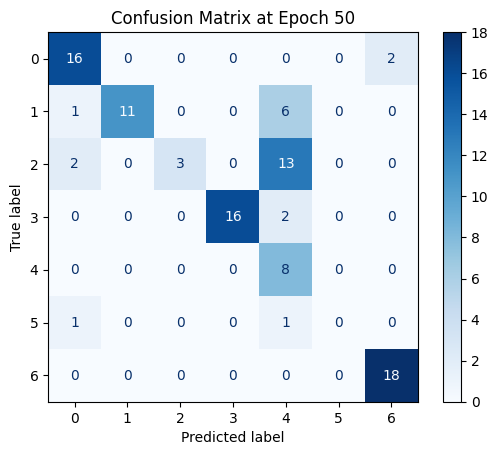

after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 51/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.05  Loss 0.56  Acc 72.17% | Val: Loss nan  Acc(top1) 54.00% | HA 0.00@0
after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 52/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.05  Loss 0.60  Acc 70.31% | Val: Loss nan  Acc(top1) 64.00% | HA 0.00@0
after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 53/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.05  Loss 0.60  Acc 68.36% | Val: Loss nan  Acc(top1) 56.00% | HA 0.00@0
after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 54/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.05  Loss 0.58  Acc 71.68% | Val: Loss nan  Acc(top1) 58.00% | HA 0.00@0
after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 55/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.05  Loss 0.59  Acc 71.39% | Val: Loss nan  Acc(top1) 64.00% | HA 0.00@0
after: len of y_pred:50, len of y_target:50
S

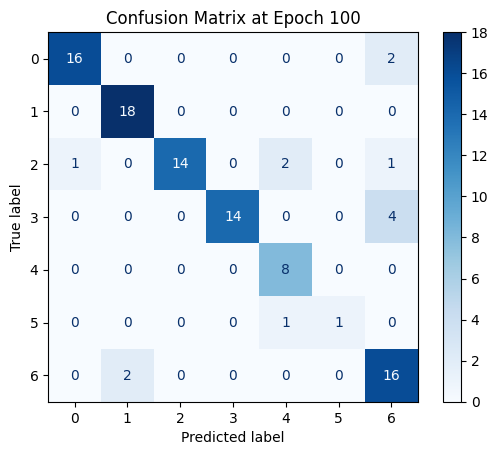

after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 101/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.005000000000000001  Loss 0.50  Acc 75.39% | Val: Loss nan  Acc(top1) 68.00% | HA 0.00@0
after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 102/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.005000000000000001  Loss 0.51  Acc 73.63% | Val: Loss nan  Acc(top1) 68.00% | HA 0.00@0
after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 103/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.005000000000000001  Loss 0.48  Acc 75.59% | Val: Loss nan  Acc(top1) 64.00% | HA 0.00@0
after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 104/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.005000000000000001  Loss 0.47  Acc 76.76% | Val: Loss nan  Acc(top1) 72.00% | HA 0.00@0
after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 105/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.005000000000000001  Loss 0.46  Acc 77.44% | Val:

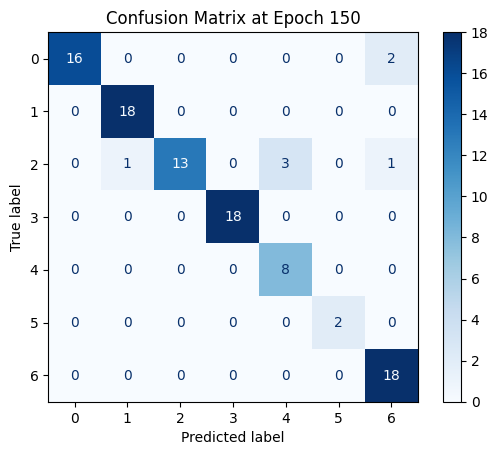

after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 151/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.005000000000000001  Loss 0.39  Acc 79.49% | Val: Loss nan  Acc(top1) 70.00% | HA 0.00@0
after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 152/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.005000000000000001  Loss 0.40  Acc 80.08% | Val: Loss nan  Acc(top1) 74.00% | HA 0.00@0
after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 153/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.005000000000000001  Loss 0.39  Acc 81.45% | Val: Loss nan  Acc(top1) 72.00% | HA 0.00@0
after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 154/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.005000000000000001  Loss 0.39  Acc 79.59% | Val: Loss nan  Acc(top1) 72.00% | HA 0.00@0
after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 155/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.005000000000000001  Loss 0.38  Acc 80.66% | Val:

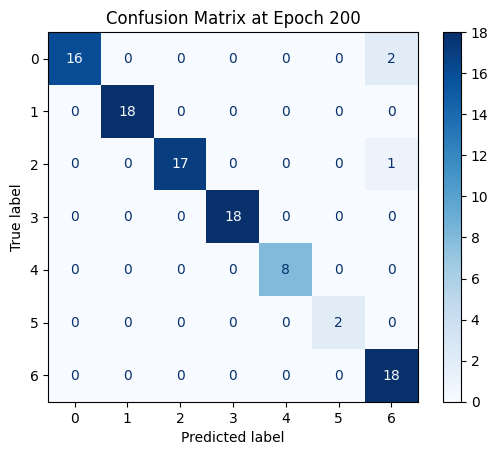

after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 201/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.005000000000000001  Loss 0.35  Acc 80.37% | Val: Loss nan  Acc(top1) 78.00% | HA 0.00@0
after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_lr0.05_bs32_wd0.0005_20240829115502/uec_model_4Classes_hacc72.0_valacc_72.0_tracc_82.91015625_202th_epoch.pt
SP-[1] Epoch: 202/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.005000000000000001  Loss 0.35  Acc 82.91% | Val: Loss nan  Acc(top1) 72.00% | HA 72.00@202
after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_lr0.05_bs32_wd0.0005_20240829115502/uec_model_4Classes_hacc74.0_valacc_74.0_tracc_82.2265625_203th_epoch.pt
SP-[1] Epoch: 203/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.005000000000000001  Loss 0.36  Acc

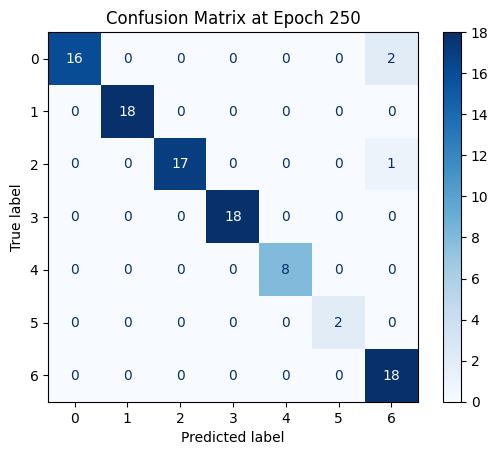

after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_lr0.05_bs32_wd0.0005_20240829115502/uec_model_4Classes_hacc82.0_valacc_76.0_tracc_80.37109375_250th_epoch.pt
SP-[1] Epoch: 251/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.005000000000000001  Loss 0.36  Acc 80.37% | Val: Loss nan  Acc(top1) 76.00% | HA 82.00@239
after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 252/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.005000000000000001  Loss 0.33  Acc 82.13% | Val: Loss nan  Acc(top1) 64.00% | HA 82.00@239
after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 253/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.005000000000000001  Loss 0.33  Acc 81.45% | Val: Loss nan  Acc(top1) 68.00% | HA 82.00@239
after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 254/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.005000000000000001  Loss 0.33  Ac

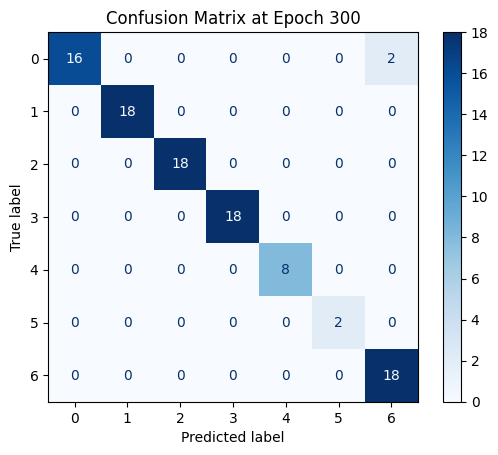

after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 301/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.0005000000000000001  Loss 0.30  Acc 83.69% | Val: Loss nan  Acc(top1) 62.00% | HA 86.00@270
after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 302/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.0005000000000000001  Loss 0.33  Acc 82.52% | Val: Loss nan  Acc(top1) 68.00% | HA 86.00@270
after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 303/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.0005000000000000001  Loss 0.32  Acc 82.32% | Val: Loss nan  Acc(top1) 70.00% | HA 86.00@270
after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 304/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.0005000000000000001  Loss 0.32  Acc 84.08% | Val: Loss nan  Acc(top1) 68.00% | HA 86.00@270
after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 305/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.0005000000000000001  Loss 0.30  

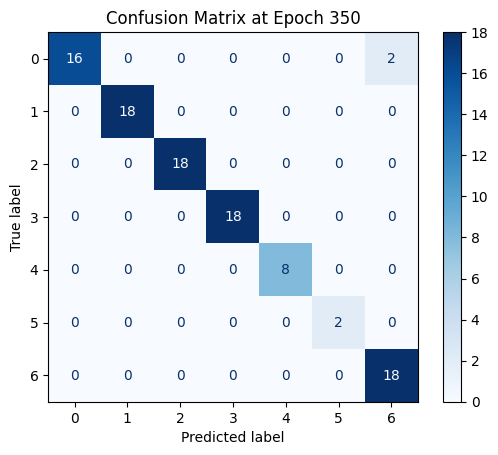

after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 351/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.0005000000000000001  Loss 0.30  Acc 84.47% | Val: Loss nan  Acc(top1) 70.00% | HA 86.00@270
after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_lr0.05_bs32_wd0.0005_20240829115502/uec_model_4Classes_hacc85.99999237060547_valacc_74.0_tracc_82.91015625_351th_epoch.pt
SP-[1] Epoch: 352/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.0005000000000000001  Loss 0.29  Acc 82.91% | Val: Loss nan  Acc(top1) 74.00% | HA 86.00@270
after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 353/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.0005000000000000001  Loss 0.30  Acc 82.52% | Val: Loss nan  Acc(top1) 70.00% | HA 86.00@270
after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/b

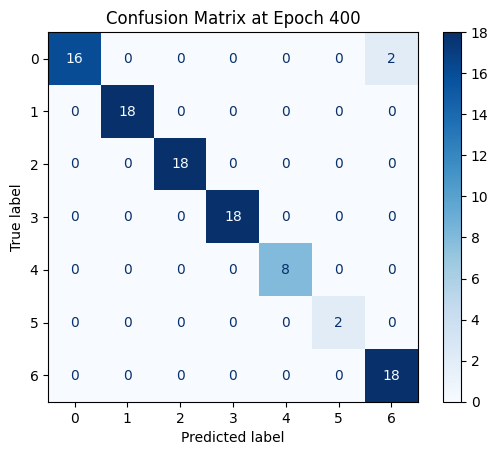

after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_lr0.05_bs32_wd0.0005_20240829115502/uec_model_4Classes_hacc85.99999237060547_valacc_84.0_tracc_83.69140625_400th_epoch.pt
SP-[1] Epoch: 401/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.0005000000000000001  Loss 0.28  Acc 83.69% | Val: Loss nan  Acc(top1) 84.00% | HA 86.00@270
after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_lr0.05_bs32_wd0.0005_20240829115502/uec_model_4Classes_hacc85.99999237060547_valacc_82.0_tracc_83.0078125_401th_epoch.pt
SP-[1] Epoch: 402/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.0005000000000000001  Loss 0.31  Acc 83.01% | Val: Loss nan  Acc(top1) 82.00% | HA 86.00@270
after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1

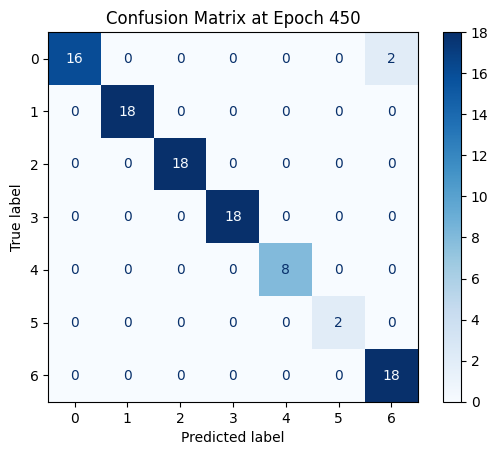

after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_lr0.05_bs32_wd0.0005_20240829115502/uec_model_4Classes_hacc88.0_valacc_78.0_tracc_85.05859375_450th_epoch.pt
SP-[1] Epoch: 451/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.0005000000000000001  Loss 0.27  Acc 85.06% | Val: Loss nan  Acc(top1) 78.00% | HA 88.00@428
after: len of y_pred:50, len of y_target:50
SP-[1] Epoch: 452/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.0005000000000000001  Loss 0.29  Acc 84.47% | Val: Loss nan  Acc(top1) 70.00% | HA 88.00@428
after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_lr0.05_bs32_wd0.0005_20240829115502/uec_model_4Classes_hacc88.0_valacc_79.99999237060547_tracc_83.49609375_452th_epoch.pt
SP-[1] Epoch: 453/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 0.000500000000000

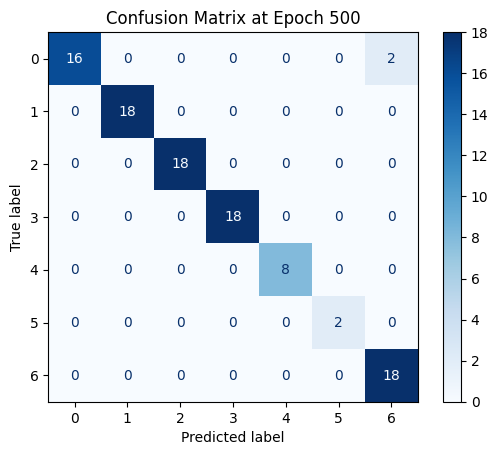

after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_lr0.05_bs32_wd0.0005_20240829115502/uec_model_4Classes_hacc88.0_valacc_72.0_tracc_84.1796875_500th_epoch.pt
SP-[1] Epoch: 501/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 5.0000000000000016e-05  Loss 0.27  Acc 84.18% | Val: Loss nan  Acc(top1) 72.00% | HA 88.00@428
after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_lr0.05_bs32_wd0.0005_20240829115502/uec_model_4Classes_hacc88.0_valacc_74.0_tracc_83.7890625_501th_epoch.pt
SP-[1] Epoch: 502/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 5.0000000000000016e-05  Loss 0.29  Acc 83.79% | Val: Loss nan  Acc(top1) 74.00% | HA 88.00@428
after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train

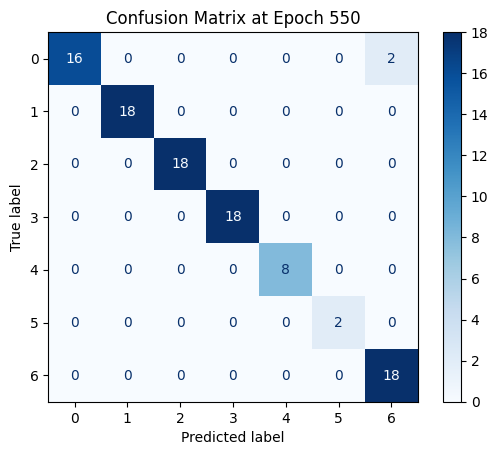

after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_lr0.05_bs32_wd0.0005_20240829115502/uec_model_4Classes_hacc88.0_valacc_74.0_tracc_84.765625_550th_epoch.pt
SP-[1] Epoch: 551/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 5.0000000000000016e-05  Loss 0.27  Acc 84.77% | Val: Loss nan  Acc(top1) 74.00% | HA 88.00@428
after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_lr0.05_bs32_wd0.0005_20240829115502/uec_model_4Classes_hacc88.0_valacc_72.0_tracc_84.9609375_551th_epoch.pt
SP-[1] Epoch: 552/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 5.0000000000000016e-05  Loss 0.28  Acc 84.96% | Val: Loss nan  Acc(top1) 72.00% | HA 88.00@428
after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_

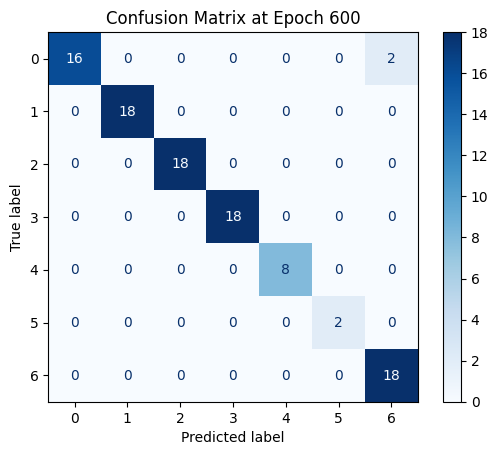

after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_lr0.05_bs32_wd0.0005_20240829115502/uec_model_4Classes_hacc88.0_valacc_74.0_tracc_85.9375_600th_epoch.pt
SP-[1] Epoch: 601/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 5.0000000000000016e-05  Loss 0.28  Acc 85.94% | Val: Loss nan  Acc(top1) 74.00% | HA 88.00@428
after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_lr0.05_bs32_wd0.0005_20240829115502/uec_model_4Classes_hacc88.0_valacc_76.0_tracc_84.66796875_601th_epoch.pt
SP-[1] Epoch: 602/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 5.0000000000000016e-05  Loss 0.27  Acc 84.67% | Val: Loss nan  Acc(top1) 76.00% | HA 88.00@428
after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_l

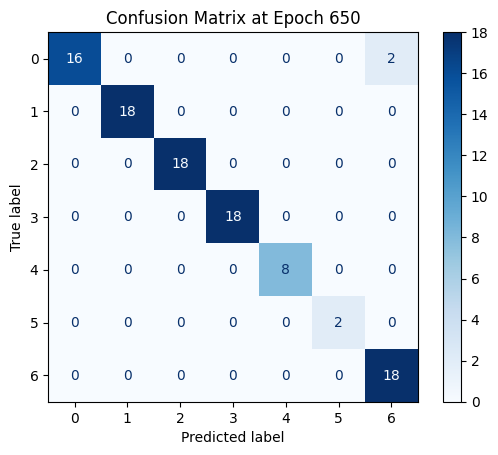

after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_lr0.05_bs32_wd0.0005_20240829115502/uec_model_4Classes_hacc88.0_valacc_76.0_tracc_82.03125_650th_epoch.pt
SP-[1] Epoch: 651/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 5.0000000000000016e-05  Loss 0.30  Acc 82.03% | Val: Loss nan  Acc(top1) 76.00% | HA 88.00@428
after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_lr0.05_bs32_wd0.0005_20240829115502/uec_model_4Classes_hacc88.0_valacc_79.99999237060547_tracc_83.984375_651th_epoch.pt
SP-[1] Epoch: 652/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 5.0000000000000016e-05  Loss 0.28  Acc 83.98% | Val: Loss nan  Acc(top1) 80.00% | HA 88.00@428
after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/ba

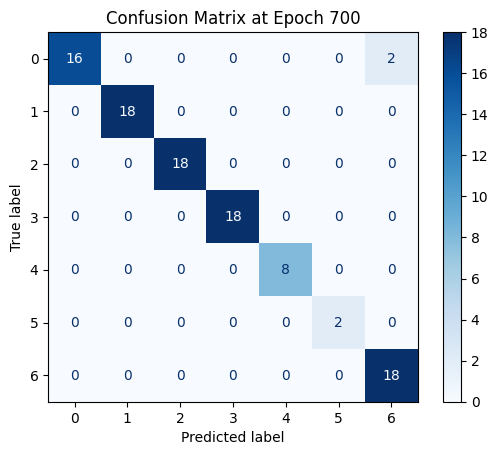

after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_lr0.05_bs32_wd0.0005_20240829115502/uec_model_4Classes_hacc88.0_valacc_74.0_tracc_83.3984375_700th_epoch.pt
SP-[1] Epoch: 701/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 5.0000000000000016e-05  Loss 0.30  Acc 83.40% | Val: Loss nan  Acc(top1) 74.00% | HA 88.00@428
after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_lr0.05_bs32_wd0.0005_20240829115502/uec_model_4Classes_hacc88.0_valacc_76.0_tracc_82.91015625_701th_epoch.pt
SP-[1] Epoch: 702/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 5.0000000000000016e-05  Loss 0.32  Acc 82.91% | Val: Loss nan  Acc(top1) 76.00% | HA 88.00@428
after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_trai

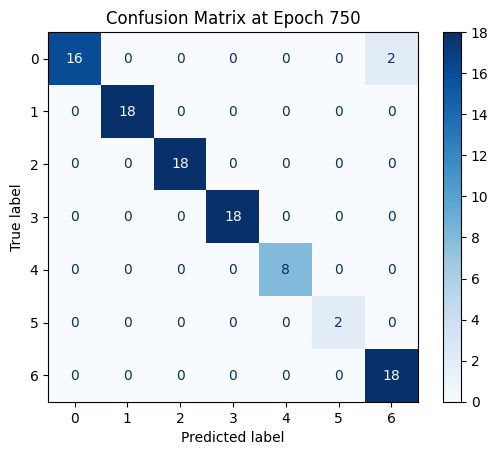

after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_lr0.05_bs32_wd0.0005_20240829115502/uec_model_4Classes_hacc88.0_valacc_78.0_tracc_82.32421875_750th_epoch.pt
SP-[1] Epoch: 751/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 5.0000000000000016e-05  Loss 0.30  Acc 82.32% | Val: Loss nan  Acc(top1) 78.00% | HA 88.00@428
after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_lr0.05_bs32_wd0.0005_20240829115502/uec_model_4Classes_hacc88.0_valacc_74.0_tracc_83.7890625_751th_epoch.pt
SP-[1] Epoch: 752/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 5.0000000000000016e-05  Loss 0.28  Acc 83.79% | Val: Loss nan  Acc(top1) 74.00% | HA 88.00@428
after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_trai

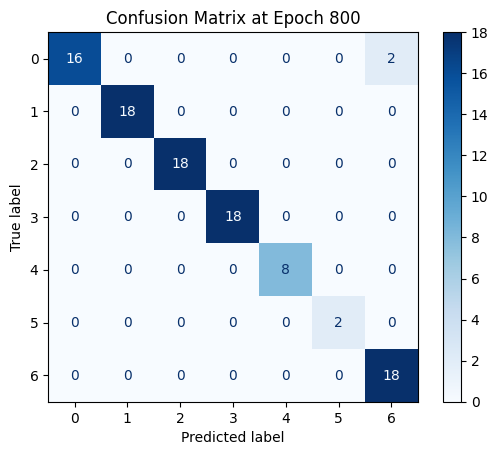

after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_lr0.05_bs32_wd0.0005_20240829115502/uec_model_4Classes_hacc88.0_valacc_78.0_tracc_85.64453125_800th_epoch.pt
SP-[1] Epoch: 801/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 5.0000000000000016e-05  Loss 0.29  Acc 85.64% | Val: Loss nan  Acc(top1) 78.00% | HA 88.00@428
after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_lr0.05_bs32_wd0.0005_20240829115502/uec_model_4Classes_hacc88.0_valacc_78.0_tracc_85.546875_801th_epoch.pt
SP-[1] Epoch: 802/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 5.0000000000000016e-05  Loss 0.28  Acc 85.55% | Val: Loss nan  Acc(top1) 78.00% | HA 88.00@428
after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train

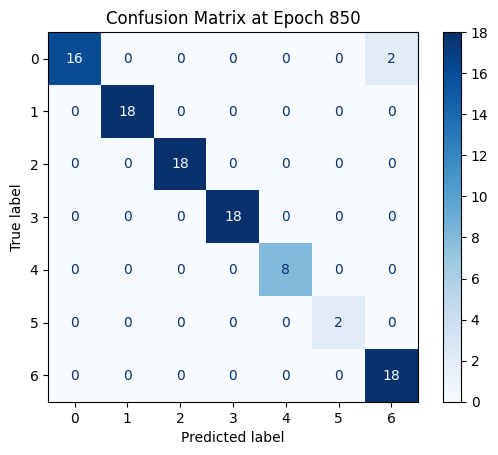

after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_lr0.05_bs32_wd0.0005_20240829115502/uec_model_4Classes_hacc88.0_valacc_79.99999237060547_tracc_83.0078125_850th_epoch.pt
SP-[1] Epoch: 851/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 5.0000000000000016e-05  Loss 0.28  Acc 83.01% | Val: Loss nan  Acc(top1) 80.00% | HA 88.00@428
after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_lr0.05_bs32_wd0.0005_20240829115502/uec_model_4Classes_hacc88.0_valacc_76.0_tracc_82.421875_851th_epoch.pt
SP-[1] Epoch: 852/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 5.0000000000000016e-05  Loss 0.30  Acc 82.42% | Val: Loss nan  Acc(top1) 76.00% | HA 88.00@428
after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/

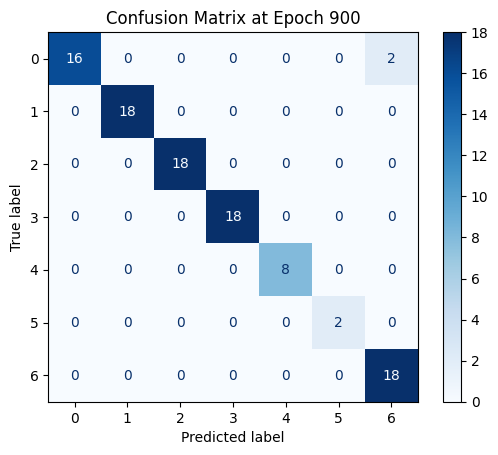

after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_lr0.05_bs32_wd0.0005_20240829115502/uec_model_4Classes_hacc88.0_valacc_76.0_tracc_85.7421875_900th_epoch.pt
SP-[1] Epoch: 901/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 5.000000000000001e-06  Loss 0.28  Acc 85.74% | Val: Loss nan  Acc(top1) 76.00% | HA 88.00@428
after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_lr0.05_bs32_wd0.0005_20240829115502/uec_model_4Classes_hacc88.0_valacc_78.0_tracc_83.30078125_901th_epoch.pt
SP-[1] Epoch: 902/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 5.000000000000001e-06  Loss 0.29  Acc 83.30% | Val: Loss nan  Acc(top1) 78.00% | HA 88.00@428
after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_

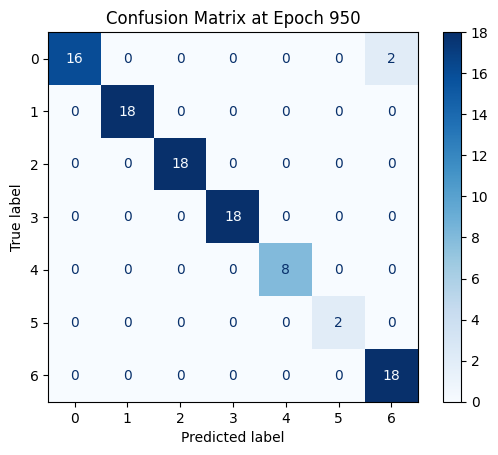

after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_lr0.05_bs32_wd0.0005_20240829115502/uec_model_4Classes_hacc88.0_valacc_72.0_tracc_85.15625_950th_epoch.pt
SP-[1] Epoch: 951/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 5.000000000000001e-06  Loss 0.28  Acc 85.16% | Val: Loss nan  Acc(top1) 72.00% | HA 88.00@428
after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_lr0.05_bs32_wd0.0005_20240829115502/uec_model_4Classes_hacc88.0_valacc_76.0_tracc_85.25390625_951th_epoch.pt
SP-[1] Epoch: 952/1000 | Time: 0m05s (Train 0m05s  Val 0m00s) | Train: LR 5.000000000000001e-06  Loss 0.29  Acc 85.25% | Val: Loss nan  Acc(top1) 76.00% | HA 88.00@428
after: len of y_pred:50, len of y_target:50
save model to /home/sail/sound_project/sound_ai_v2/STEP/step_1/save_pt_model_s1/20240829_11/base4C_train_lr

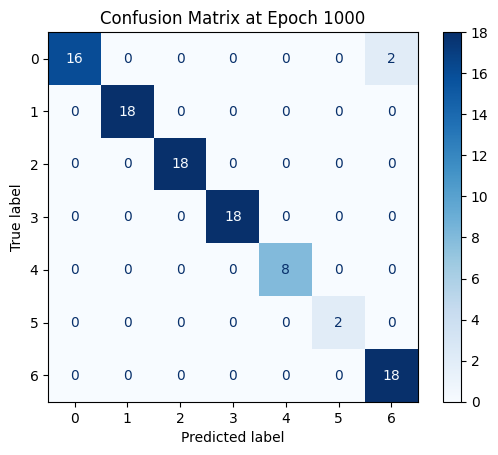

Execution finished in: 1h28m


In [55]:
main()